In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

DEBUG = False

relPath = "../results/"
# ("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR),
cliMeasNames = [("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]
rep = 15
numClients = 1
numServers = 2

fileNamesSca = []
fileNamesVec = []


simName = "MMS_DoS_Wired_Multi_Server"
for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


Function to create the statistics filter

In [142]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [143]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

Plot client measures for each client aggregating all the repetitions 

In [144]:
def plotBoxWisker(measNames, numClients, numServers, title = "", cli = "client", mode = StatType.SCALAR):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(10)
    fig.set_figwidth(25)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR and meas[1] == mode:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                elif meas[1] == StatType.VECTOR and meas[1] == mode:
                    flt = vec[vec["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box = None
                    rowNum = 0
                    for row in flt.itertuples():
                        vecValue = pd.Series(row.vecvalue)
                        vecTime = pd.Series(row.vectime)
                        if box is None:
                            box = pd.DataFrame(columns=vecTime)
                        box.loc[rowNum] = vecValue.tolist()
                        rowNum += 1                    
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            box.boxplot(ax=axes[j], grid=False, rot=90)
            axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
    return outVec

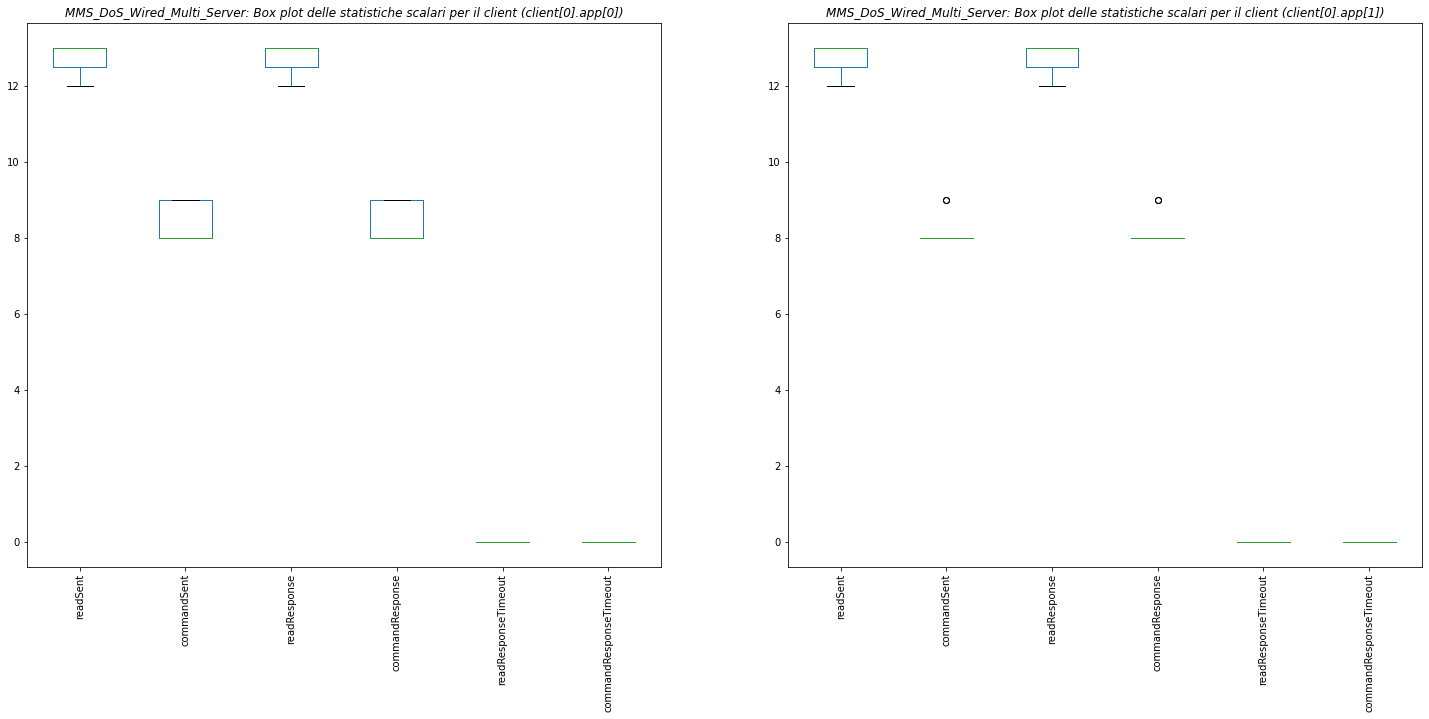

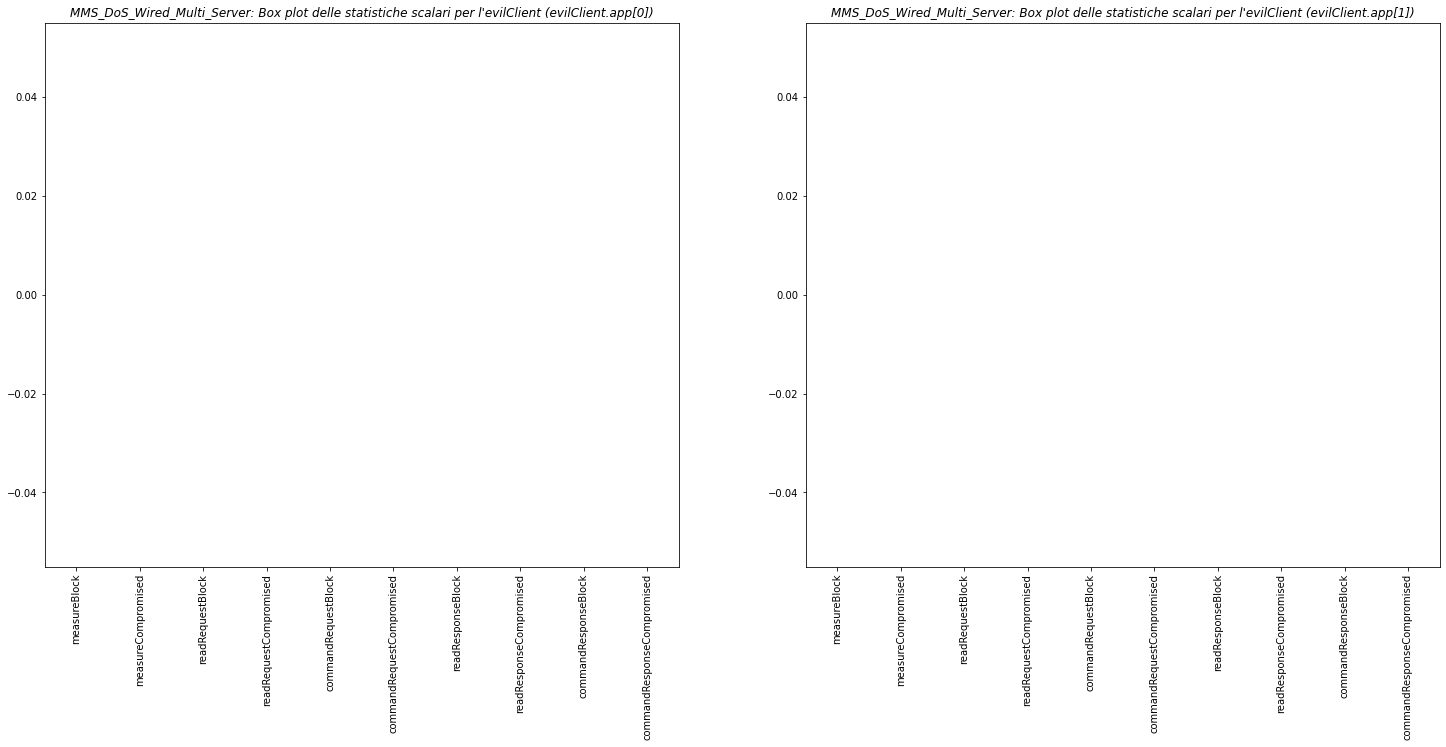

In [145]:
cliScaDfList = plotBoxWisker(cliMeasNames, numClients, numServers, title=simName + ": Box plot delle statistiche scalari per il client")
evilScaDfList = plotBoxWisker(evilMeasNames, 1, numServers, cli="evilClient", title=simName + ": Box plot delle statistiche scalari per l'evilClient")

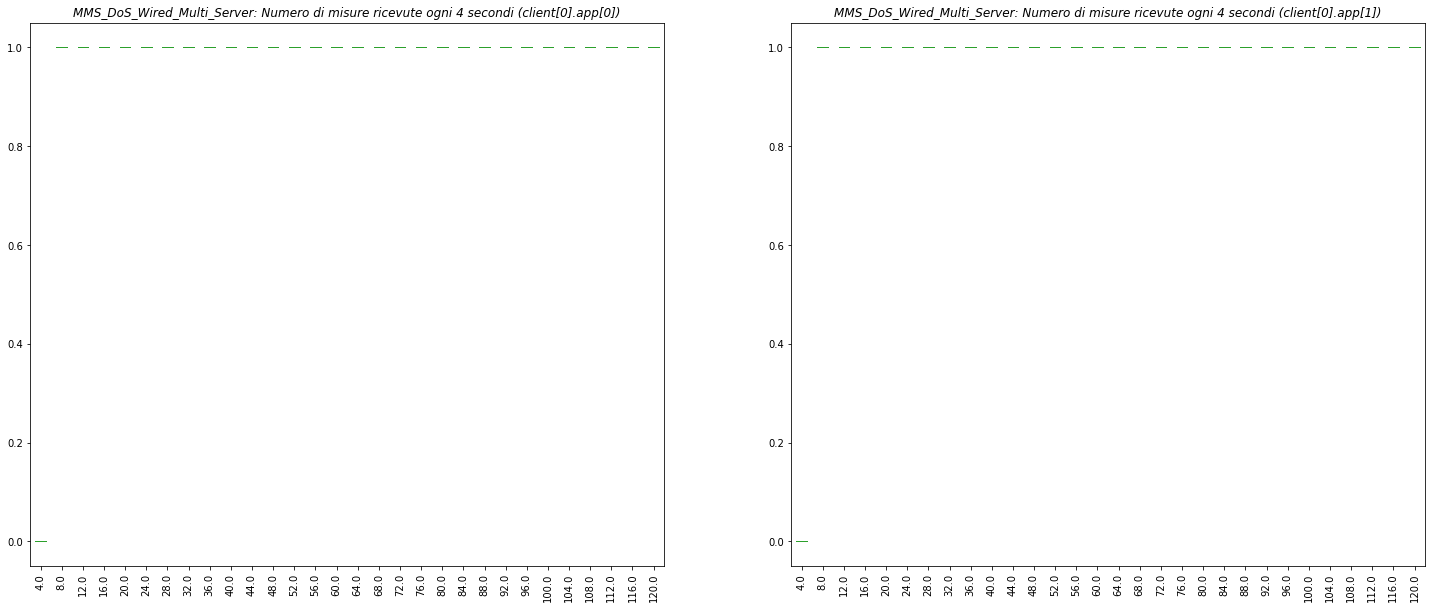

In [146]:
cliVecDfList = plotBoxWisker(cliMeasNames, numClients, numServers, mode=StatType.VECTOR, title=simName + ": Numero di misure ricevute ogni 4 secondi")

In [147]:
def confidenceInterval(data, confidence = 0.95):
    for (colName, colData) in data.iteritems():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        
        # m, m-h, m+h
        print("## Stat: " + colName)
        print("Average: " + str(m))
        print("Quantile: +-" + str(h)) 

Confidence interval for the different statistics

In [148]:
conf = 0.98
for i in range(numClients):
    for j in range(numServers):
        print("\n** " + simName + ": Confidence intervals for client[" + str(i) + "].app[" + str(j) + "] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(i+1)*j], conf)


** MMS_DoS_Wired_Multi_Server: Confidence intervals for client[0].app[0] at 98.0%  **
## Stat: readSent
Average: 12.733333333333333
Quantile: +-0.3101820463263004
## Stat: commandSent
Average: 8.4
Quantile: +-0.3436269350159229
## Stat: readResponse
Average: 12.733333333333333
Quantile: +-0.3101820463263004
## Stat: commandResponse
Average: 8.4
Quantile: +-0.3436269350159229
## Stat: readResponseTimeout
Average: 0.0
Quantile: +-0.0
## Stat: commandResponseTimeout
Average: 0.0
Quantile: +-0.0

** MMS_DoS_Wired_Multi_Server: Confidence intervals for client[0].app[1] at 98.0%  **
## Stat: readSent
Average: 12.733333333333333
Quantile: +-0.3101820463263004
## Stat: commandSent
Average: 8.133333333333333
Quantile: +-0.23843883570780172
## Stat: readResponse
Average: 12.733333333333333
Quantile: +-0.3101820463263004
## Stat: commandResponse
Average: 8.133333333333333
Quantile: +-0.23843883570780172
## Stat: readResponseTimeout
Average: 0.0
Quantile: +-0.0
## Stat: commandResponseTimeout
Ave

In [149]:
for j in range(numServers):
    print("\n** " + simName + ": Confidence intervals for evilClient.app[" + str(j) + "] at " + str(conf*100) + "%  **")
    confidenceInterval(evilScaDfList[j], conf)


** MMS_DoS_Wired_Multi_Server: Confidence intervals for evilClient.app[0] at 98.0%  **
## Stat: measureBlock
Average: nan
Quantile: +-nan
## Stat: measureCompromised
Average: nan
Quantile: +-nan
## Stat: readRequestBlock
Average: nan
Quantile: +-nan
## Stat: readRequestCompromised
Average: nan
Quantile: +-nan
## Stat: commandRequestBlock
Average: nan
Quantile: +-nan
## Stat: commandRequestCompromised
Average: nan
Quantile: +-nan
## Stat: readResponseBlock
Average: nan
Quantile: +-nan
## Stat: readResponseCompromised
Average: nan
Quantile: +-nan
## Stat: commandResponseBlock
Average: nan
Quantile: +-nan
## Stat: commandResponseCompromised
Average: nan
Quantile: +-nan

** MMS_DoS_Wired_Multi_Server: Confidence intervals for evilClient.app[1] at 98.0%  **
## Stat: measureBlock
Average: nan
Quantile: +-nan
## Stat: measureCompromised
Average: nan
Quantile: +-nan
## Stat: readRequestBlock
Average: nan
Quantile: +-nan
## Stat: readRequestCompromised
Average: nan
Quantile: +-nan
## Stat: com

/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/dosclic98/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
